### **Finding Order For SARIMA Model**

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
from joblib import Parallel, delayed

# Load the dataset
data = pd.read_csv('sixcrypto.csv', parse_dates=['Date'], index_col='Date')

# Define the SARIMA model parameters
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
P = range(0, 3)
D = range(0, 3)
Q = range(0, 3)
m = 12

# Create a function to fit and evaluate a SARIMA model
def fit_evaluate_model(params, train_data, test_data):
    try:
        # Fit a SARIMA model to the training data
        model = sm.tsa.SARIMAX(train_data['Close'], order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], m), trend='c')
        results = model.fit()

        # Make predictions on the testing data
        predictions = results.predict(start=test_data.index[0], end=test_data.index[-1])

        # Evaluate the predictions using MAE, RMSE, and MAPE
        mae = mean_absolute_error(test_data['Close'], predictions)
        mse = mean_squared_error(test_data['Close'], predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test_data['Close'] - predictions) / test_data['Close'])) * 100
        corr = np.corrcoef(predictions, test_data['Close'])[0, 1]

        # Return the parameter values and evaluation metrics
        return [params, mae, mse, rmse, mape, corr]

    except:
        pass

# Define the number of CPU cores to use for parallel processing
num_cores = 12

# Loop through all the currencies in the dataset
currencies = data['Symbol'].unique()
results_list = []

for currency in currencies:
    print('Processing', currency, '...')
    
    # Split the data into training and testing sets
    currency_data = data[data['Symbol'] == currency]
    train_data = currency_data[currency_data.index < '2021-01-01']
    test_data = currency_data[currency_data.index >= '2021-01-01']
    
    # Run the SARIMA model on the currency data
    # Loop through all possible combinations of parameters and run them in parallel
    results = Parallel(n_jobs=num_cores)(delayed(fit_evaluate_model)(params, train_data, test_data) for params in itertools.product(p, d, q, P, D, Q))

    # Remove any None values from the list of results
    results = [r for r in results if r is not None]

    # Convert the list of results to a pandas DataFrame
    results_df = pd.DataFrame(results, columns=['Parameters', 'MAE', 'MSE', 'RMSE', 'MAPE', 'Correlation'])

    # Sort the results by the lowest MAE
    results_df.sort_values(by='MAE', inplace=True)

    # Append the results to the results list
    results_list.append((currency, results_df))

# Print the best parameters and evaluation metrics for each currency
for currency, results_df in results_list:
    print(currency, ':')
    print(results_df.head(1))

Processing LTC ...
Processing ADA ...
Processing BNB ...
Processing DOGE ...
Processing ETH ...
Processing BTC ...
LTC :
             Parameters       MAE          MSE       RMSE      MAPE  \
681  (2, 2, 1, 0, 2, 2)  49.80231  4272.468034  65.364119  26.66508   

     Correlation  
681     0.181961  
ADA :
             Parameters       MAE       MSE      RMSE       MAPE  Correlation
686  (2, 2, 1, 1, 0, 2)  0.349432  0.194924  0.441502  30.696202     0.755302
BNB :
             Parameters         MAE           MSE        RMSE       MAPE  \
689  (2, 2, 1, 1, 2, 0)  134.992353  32555.326762  180.430947  39.435371   

     Correlation  
689     0.549649  
DOGE :
            Parameters       MAE       MSE      RMSE       MAPE  Correlation
96  (0, 1, 0, 1, 2, 0)  0.150407  0.046807  0.216349  69.299579     0.739248
ETH :
            Parameters         MAE            MSE       RMSE       MAPE  \
87  (0, 1, 0, 0, 2, 0)  575.170057  504761.951932  710.46601  27.672632   

    Correlation  
87 

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Loop through all currencies and fit a SARIMA model using the best parameters obtained earlier
models = {}
for (currency, results_df) in results_list:
    # Get the best parameters for the currency
    best_params = results_df.iloc[0]['Parameters']
    
    # Split the currency data into training and testing sets
    currency_data = data[data['Symbol'] == currency]
    currency_data.index.freq = 'D'
    train_data = currency_data[currency_data.index < '2021-01-01']
    test_data = currency_data[currency_data.index >= '2021-01-01']

    # Fit a SARIMA model with the best parameters to the training data
    model = sm.tsa.SARIMAX(train_data['Close'], order=(best_params[0], best_params[1], best_params[2]), 
                            seasonal_order=(best_params[3], best_params[4], best_params[5], m), trend='c')
    results = model.fit()

    # Store the model for the currency
    models[currency] = results

# Print the summary output for all models in a single window
for symbol, result in models.items():
    print(f"Summary for {symbol}:")
    print(result.summary())
    print("="*60)

Summary for LTC:
                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                 1461
Model:             SARIMAX(2, 2, 1)x(0, 2, [1, 2], 12)   Log Likelihood               -4830.547
Date:                                 Sun, 02 Apr 2023   AIC                           9675.094
Time:                                         20:29:42   BIC                           9711.977
Sample:                                     01-01-2017   HQIC                          9688.865
                                          - 12-31-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.288e-06   1.12e-05     -0.205      0.838   

### **Visualize the SARIMA Model**

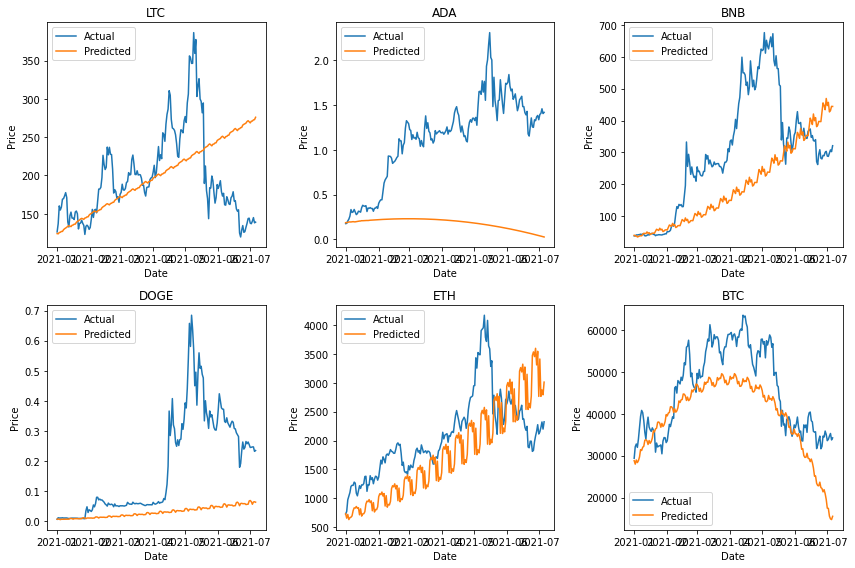

In [7]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Loop through the results for each currency and plot the actual and predicted values
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
for (currency, results_df), ax in zip(results_list, axes.flatten()):
    # Get the best parameters for the currency
    best_params = results_df.iloc[0]['Parameters']
    
    # Split the currency data into training and testing sets
    currency_data = data[data['Symbol'] == currency]
    currency_data.index.freq = 'D'
    train_data = currency_data[currency_data.index < '2021-01-01']
    test_data = currency_data[currency_data.index >= '2021-01-01']
    
    # Fit a SARIMA model with the best parameters to the training data
    model = sm.tsa.SARIMAX(train_data['Close'], order=(best_params[0], best_params[1], best_params[2]), seasonal_order=(best_params[3], best_params[4], best_params[5], m), trend='c')
    results = model.fit()

    # Make predictions on the testing data
    predictions = results.predict(start=test_data.index[0], end=test_data.index[-1])
    
    # Plot the actual and predicted values
    ax.plot(test_data.index, test_data['Close'], label='Actual')
    ax.plot(test_data.index, predictions, label='Predicted')
    ax.set_title(currency)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
                
   
plt.tight_layout()
plt.show()

In [8]:
# Loop through all currencies and fit a SARIMA model using the best parameters obtained earlier
models = {}
eval_metrics = {}
for (currency, results_df) in results_list:
    # Get the best parameters for the currency
    best_params = results_df.iloc[0]['Parameters']
    
    # Split the currency data into training and testing sets
    currency_data = data[data['Symbol'] == currency]
    currency_data.index.freq = 'D'
    train_data = currency_data[currency_data.index < '2021-01-01']
    test_data = currency_data[currency_data.index >= '2021-01-01']

    # Fit a SARIMA model with the best parameters to the training data
    model = sm.tsa.SARIMAX(train_data['Close'], order=(best_params[0], best_params[1], best_params[2]), 
                            seasonal_order=(best_params[3], best_params[4], best_params[5], m), trend='c')
    results = model.fit()

    # Store the model and evaluation metrics for the currency
    models[currency] = results
    eval_metrics[currency] = {'MAE': mean_absolute_error(test_data['Close'], results.forecast(len(test_data))),
                              'MSE': mean_squared_error(test_data['Close'], results.forecast(len(test_data))),
                              'RMSE': np.sqrt(mean_squared_error(test_data['Close'], results.forecast(len(test_data)))),
                              'MAPE': np.mean(np.abs((test_data['Close'] - results.forecast(len(test_data))) / test_data['Close'])) * 100,
                              'Correlation': np.corrcoef(results.forecast(len(test_data)), test_data['Close'])[0, 1]}

# Print the evaluation metrics for all currencies
for symbol, metrics in eval_metrics.items():
    print(f"Evaluation metrics for {symbol}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("="*60)

Evaluation metrics for LTC:
MAE: 49.80231027916544
MSE: 4272.468033842892
RMSE: 65.3641188561652
MAPE: 26.665079991341912
Correlation: 0.1819608354176902
Evaluation metrics for ADA:
MAE: 0.9560115693570972
MSE: 1.1619951381674452
RMSE: 1.077958783148709
MAPE: 76.20530421646941
Correlation: -0.4648544685041373
Evaluation metrics for BNB:
MAE: 135.17889867462722
MSE: 33729.98201658687
RMSE: 183.65724057762296
MAPE: 38.89573792615714
Correlation: 0.5612589908221423
Evaluation metrics for DOGE:
MAE: 0.15040692218916843
MSE: 0.04680707795313064
RMSE: 0.21634943483432223
MAPE: 69.29957887389581
Correlation: 0.7392477883516307
Evaluation metrics for ETH:
MAE: 575.1700572022384
MSE: 504761.9519319901
RMSE: 710.4660103988016
MAPE: 27.672632263342322
Correlation: 0.6318428024383742
Evaluation metrics for BTC:
MAE: 7353.099445236613
MSE: 74825610.68304752
RMSE: 8650.179806399838
MAPE: 16.16454912471208
Correlation: 0.8098069334667024


### **Feature Imporatance**

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Read data from CSV file
df = pd.read_csv("sixcrypto.csv")

# Create a dictionary to store feature importance results
feature_importance = {"High": {}, "Low": {}, "Open": {}, "Volume": {}, "Marketcap": {}}

# Loop through each cryptocurrency
for symbol in df["Symbol"].unique():
    # Subset data for the current cryptocurrency
    subset = df[df["Symbol"] == symbol].reset_index(drop=True)
    
    # Split data into train and test sets
    train_size = int(len(subset) * 0.8)
    train_data = subset[:train_size]
    test_data = subset[train_size:]
    
    # Train random forest and gradient boosting models on training data
    rf_model = RandomForestRegressor()
    gb_model = GradientBoostingRegressor()
    rf_model.fit(train_data[["High", "Low", "Open", "Volume", "Marketcap"]], train_data["Close"])
    gb_model.fit(train_data[["High", "Low", "Open", "Volume", "Marketcap"]], train_data["Close"])
    
    # Store feature importance results for the current cryptocurrency
    for feature, importance in zip(["High", "Low", "Open", "Volume", "Marketcap"], rf_model.feature_importances_):
        feature_importance[feature][symbol+"_RF"] = importance
    for feature, importance in zip(["High", "Low", "Open", "Volume", "Marketcap"], gb_model.feature_importances_):
        feature_importance[feature][symbol+"_GB"] = importance

# Convert feature importance dictionary to dataframe
feature_importance_df = pd.DataFrame(feature_importance)

# Print feature importance results
print(feature_importance_df)

             High       Low      Open    Volume  Marketcap
LTC_RF   0.646200  0.195953  0.007486  0.000134   0.150227
LTC_GB   0.551614  0.158101  0.000065  0.000264   0.289956
ADA_RF   0.194352  0.059120  0.007975  0.000354   0.738198
ADA_GB   0.070260  0.027498  0.000011  0.000008   0.902223
BNB_RF   0.377138  0.607779  0.006406  0.000323   0.008353
BNB_GB   0.472430  0.483788  0.000201  0.000264   0.043316
DOGE_RF  0.163937  0.039501  0.008185  0.001284   0.787092
DOGE_GB  0.131498  0.037654  0.000857  0.003942   0.826049
ETH_RF   0.251095  0.129137  0.001213  0.000107   0.618448
ETH_GB   0.282372  0.167983  0.000051  0.000060   0.549533
BTC_RF   0.266107  0.342006  0.005192  0.000310   0.386385
BTC_GB   0.255079  0.211205  0.001156  0.000269   0.532291
